In [1]:
#importing the required scripts
from Scripts.ProcessingEmbeddings import *
import Scripts.utils as utils
from Scripts.HardDebias import *

#Importing the required packages
import numpy as np
import pandas as pd



In [2]:
#Creating an embeddings object: 400k words, 50 dimensions
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)




Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [3]:
# From the embeddings object, get the vectors, the word2idx dictionary, the vocab list, and the dict_vectors dictionary
# Because the gensim embeddings carry no information on the file, we need to use the built-in function from gensim to get the vocab in descending frequency.
glove.model.sort_by_descending_frequency()
vectors = glove.vectors
word2idx = glove.word2idx
vocab = glove.words
dict_vectors = glove.get_word_vector_dict()

#print the first 20 words in the vocab
print(vocab[:20])

#Print the shape of the vectors
print("vectors shape", vectors.shape)

#Print a boolean to check if there are any NaNs in the vectors
print("Missing values in vectors?", np.isnan(vectors).any())




['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']
vectors shape (400000, 300)
Missing values in vectors? False


In [4]:
#Removing puntuation and numbers from the embeddings
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab)



100%|██████████| 400000/400000 [00:00<00:00, 609836.87it/s]


Size of limited vocabulary: 327185


  ## Hard-Debias Algorithm

  #### Preliminaries

In [6]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets = {
    "gender": [
        ['she', 'he'], ['herself', 'himself'], 
        ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
        ['mother', 'father'], ['woman', 'man'], ['mary', 'john'],
        ['gal', 'guy'], ['female', 'male'], ['aunt', 'uncle']],

    "race": [
        ["black", "caucasian", "asian", "hispanic"],
      		["african", "caucasian", "asian", "hispanic"],
      		["black", "white", "asian", "latino"],
      		["africa", "europe", "asia", "mexico"],
      		["africa", "america", "china", "latin-america"],
    ]
}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], 
        ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], 
        ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], 
        ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], 
        ["brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman","congresswoman"], 
        ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"],
        ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], 
        ["gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], 
        ["his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"],
        ["men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], 
        ["twin_brother", "twin_sister"]]}

#Words taken from Wang et al. to enrich the equalizing pairs
female_vocab = ['countrywoman',  'witches',  'maidservant',  'mothers',  'diva',  'actress',  'spinster',  'mama',  'duchesses',  'countrywomen',  'hostesses',  'suitors',  'menopause',  'clitoris',  'princess',  'governesses',  'abbess',  'women',  'widow',  'ladies',  'sorceresses',  'madam',  'brides',  'baroness',  'niece',  'widows',  'lady',  'sister',  'brides',  'nun',  'obstetrics',  'her',  'marchioness',  'princesses',  'empresses',  'mare',  'chairwoman',  'convent',  'priestesses',  'girlhood',  'ladies',  'queen',  'gals',  'mommies',  'maid',  'spokeswoman',  'seamstress',  'cowgirls',  'chick',  'spinsters',  'empress',  'mommy',  'gals',  'enchantress',  'gal',  'motherhood',  'estrogen',  'godmother',  'strongwoman',  'goddess',  'matriarch',  'aunt',  'chairwomen',  'maam',
                'sisterhood',  'hostess',  'estradiol',  'wife',  'mom',  'stewardess',  'females',  'spokeswomen',  'ma',  'belle',  'minx',  'maiden',  'witch',  'miss',  'nieces',  'mothered',  'cow',  'belles',  'granddaughter',  'fiancees',  'stepmothers',  'grandmothers',  'schoolgirl',  'hen',  'granddaughters',  'bachelorette',  'camerawoman',  'moms',  'her',  'mistress',  'lass',  'policewoman',  'nun',  'actresses',  'saleswomen',  'girlfriend',  'councilwoman',  'lady',  'stateswoman',  'maternal',  'lass',  'landlady',  'ladies',  'wenches',  'sorority',  'duchess',  'ballerina',  'chicks',  'fiancee',  'fillies',  'wives',  'she',  'businesswoman',  'masseuses',  'heroine',  'doe',  'girlfriends',  'queens',  'sisters',  'stepmother',  'daughter',  'cowgirl',  'daughters',  'soprano',
                'saleswoman',  'mistress',  'nuns',  'headmistresses',  'lasses',  'congresswoman',  'housewife',  'priestess',  'abbesses',  'toque',  'sororities',  'stewardesses',  'filly',  'czarina',  'stepdaughters',  'herself',  'girls',  'lionesses',  'lady',  'vagina',  'hers',  'masseuse',  'cows',  'aunts',  'wench',  'toques',  'wife',  'lioness',  'sorceress',  'mother',  'lesbians',  'female',  'waitresses',  'ovum',  'ovary',  'stepdaughter',  'businesswomen',  'heiress',  'waitress',  'headmistress',  'woman',  'governess',  'bride',  'grandma',  'bride',  'gal',  'lesbian',  'ladies',  'girl',  'grandmother',  'mare',  'hens',  'nuns',  'maidservants',  'heroines']
male_vocab = ['countryman',  'wizards',  'manservant',  'fathers',  'divo',  'actor',  'bachelor',  'papa',  'dukes',  'countrymen',  'hosts',  'airmen',  'andropause',  'penis',  'prince',  'governors',  'abbot',  'men',  'widower',  'gentlemen',  'sorcerers',  'sir',  'bridegrooms',  'baron',  'nephew',  'widowers',  'lord',  'brother',  'grooms',  'priest',  'andrology',  'his',  'marquis',  'princes',  'emperors',  'stallion',  'chairman',  'monastery',  'priests',  'boyhood',  'fellas',  'king',  'dudes',  'daddies',  'manservant',  'spokesman',  'tailor',  'cowboys',  'dude',  'bachelors',  'emperor',  'daddy',  'guys',  'enchanter',  'guy',  'fatherhood', 
                'androgen',  'godfather',  'strongman',  'god',  'patriarch',  'uncle',  'chairmen',  'sir',  'brotherhood',  'host',  'testosterone',  'husband',  'dad',  'steward',  'males',  'spokesmen',  'pa',  'beau',  'stud',  'bachelor',  'wizard',  'sir',  'nephews',  'fathered',  'bull',  'beaus',  'grandson',  'fiances',  'stepfathers',  'grandfathers',  'schoolboy',  'rooster',  'grandsons',  'bachelor',  'cameraman',  'dads',  'him',  'master',  'lad',  'policeman',  'monk',  'actors',  'salesmen',  'boyfriend',  'councilman',  'fella',  'statesman',  'paternal',  'chap',  'landlord',  'lords',  'blokes',  'fraternity',  'duke',  'dancer',  'dudes',  'fiance',
                'colts',  'husbands',  'he',  'businessman',  'masseurs',  'hero',  'deer',  'boyfriends',  'kings',  'brothers',  'stepfather',  'son',  'cowboy',  'sons',  'baritone',  'salesman',  'paramour',  'monks',  'headmasters',  'lads',  'congressman',  'househusband',  'priest',  'abbots',  'beard',  'fraternities',  'stewards',  'colt',  'czar',  'stepsons',  'himself',  'boys',  'lions',  'gentleman',  'penis',  'his',  'masseur',  'bulls',  'uncles',  'bloke',  'beards',  'hubby',  'lion',  'sorcerer',  'father',  'gays',  'male',  'waiters',  'sperm',  'prostate',  'stepson',  'businessmen',  'heir',  'waiter',  'headmaster',  'man',  'governor',  'bridegroom', 
                'grandpa',  'groom',  'dude',  'gay',  'gents',  'boy',  'grandfather',  'gelding',  'roosters',  'priests',  'busboy',  'heros']

#added the gendered pairs to the equalizing list (equalizing_lists['gender'] if the pairs are not there already
gendered_pairs = list(zip(male_vocab, female_vocab))
list_pairs = [tuple for tuple in gendered_pairs if tuple not in equalizing_lists['gender']]
equalizing_lists['gender'] = equalizing_lists['gender']+list_pairs

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.




In [7]:
#Preparing the definite sets for debiasing
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])




  ## Evaluation of Slight changes to the algorithm

In [8]:
from Scripts.Visualization import *
from Scripts.Evaluation import *



  ### Setting up parameters and combinations

In [9]:
# Importing the dataset with all parameter combinations: 
# norm_direction is a parameter that determines whether the bias direction is normalized or not
# normalize is a parameter that determines whether the word vectors are normalized before or after debiasing
# centralize is a parameter that determines whether the word vectors are centered before using PCA to find the bias subspace
import pandas as pd
parameters = pd.read_csv('Data/all_parameter_combinations.csv', header=0)
parameters




norm_direction normalize  centralize
0            False      None       False
1            False      None        True
2            False     after       False
3            False     after        True
4            False    before       False
5            False    before        True
6             True      None       False
7             True      None        True
8             True     after       False
9             True     after        True
10            True    before       False
11            True    before        True

In [10]:
#Defining variables for the analysis
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']
occupations = ['assistant', 'secretary', 'data scientist', 'scientist', 'politician', 'janitor', 'hairdresser', 'teacher',
                'bartender', 'midwife', 'doctor', 'ballerina', 'dancer', 'pediatrician', 'surgeon', 'physician', 'shopkeeper', 
                  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists',
                    'guitarists', 'carpenter', 'clerk', 'manager', 'supervisor', 'driver',
               'software developer', 'lawyer', 'pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 
               'chancellor', 'maestro', 'lecturer', 'salesperson', 'homemaker', 'receptionist', 'librarian', 'nanny', 'bookkeeper',
                 'stylist', 'housekeeper', 'guidance counselor', 'skipper', 'protege', 'philosopher', 'captain', 'architect', 'financier',
                 'warrior', 'broadcaster', 'magician', 'figher', 'pilot', 'boss']



In [11]:
#Function that gets all the debiased vectors, vocabularies and word2idx dictionaries for all parameter combinations and stores them in a dictionary
def get_debiased_vectors(vectors, dict_vectors, word2idx_cleaned,
                         vocab_cleaned,
                         equalizing_lists,
                         def_set, parameters_df):
    grand_dictionary = {}
    #loop over indexes of the df
    for i in range(len(parameters_df)):
        #run the hard_debias function with the parameters of the row and generate a dictionary with the results: key=index, value:dictionary, key=name (vectors, vocab, word2idx), value: the result of the function
        debiased_vectors, debiased_vocab, debiased_word2idx, debiased_dict = hard_debias(vectors,
                                                                                         dict_vectors,
                                                                                         word2idx_cleaned,
                                                                                         vocab_cleaned,
                                                                                         equalizing_lists,
                                                                                         def_set,
                                                                                         1,
                                                                                         normalize_dir=parameters_df.iloc[
                                                                                             i][0],
                                                                                         normalize=parameters_df.iloc[i][1],
                                                                                         centralizing=parameters_df.iloc[i][2])

        #add the variables to the grand dictionary
        grand_dictionary[i] = {'vectors': debiased_vectors, 'vocab': debiased_vocab,
                               'word2idx': debiased_word2idx, 'dict': debiased_dict}

    return grand_dictionary




In [12]:
#getting the grand dictionary
grand_dict=get_debiased_vectors(vectors, dict_vec_cleaned, word2idx_cleaned,
                     vocab_cleaned,
                     equalizing_lists['gender'],
                     def_set_gender, parameters)




Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components


  ### Bias Pre-Post of selected words.
  Using the original and debiased vectors, I calculate bias scores in two ways:
  1. Simple Bias Score: cos(v, she_embed)-cos(v, he_embed) for every v in the vocabulary
  2. Direct bias score: following Bolukbasi et al. 2016

  With this, I get a measure of the debiasing effects per word or the chosen list.

In [13]:
#Getting the original simple bias as baseline
gender_bias_original = compute_gender_simple_bias(
    dict_vec_cleaned, he_embed, she_embed)

In [14]:
#Gets a dictionary with the bias scores for all the words in the dataset for all parameter combinations
def get_debiased_vectors_scores_plots(grand_dict, dict_vectors, parameters_df, he_embed, she_embed, def_set_gender):
    scores_dictionary = {}

    #loop over indexes of the df
    for i in range(len(parameters_df)):
        #debiased_vectors=grand_dict[i]['vectors']
        #debiased_vocab=grand_dict[i]['vocab']
        #debiased_word2idx=grand_dict[i]['word2idx']
        debiased_dict = grand_dict[i]['dict']

        # Using the gender bias function to compute the bias of all the words in the limited dataset
        #We create a dictionary with the word as key and the bias as value
        gender_bias_after_debiasing = compute_gender_simple_bias(
            debiased_dict, he_embed, she_embed)

        gender_direction = identify_bias_subspace(
            dict_vectors, def_set_gender, 1, centralizing=parameters_df.iloc[i][2])
        if parameters_df.iloc[i][0]:
            gender_direction = utils.normalize(gender_direction)

        #use compute_direct_bias to get the scores
        direct_gender_bias_original = compute_similarity_to_bias_direction(
            dict_vectors, gender_direction)
        direct_gender_bias_debiased = compute_similarity_to_bias_direction(
            debiased_dict, gender_direction)

        scores_dictionary[i] = {'simple_bias': gender_bias_after_debiasing,
                                'direct_bias_original': direct_gender_bias_original,
                                'direct_bias_debiased': direct_gender_bias_debiased}
    return scores_dictionary




In [15]:
#Getting the scores dictionary
scores_dictionary = get_debiased_vectors_scores_plots(
    grand_dict,dict_vectors, parameters, he_embed, she_embed, def_set_gender)




Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components


In [16]:
#Function to get a bar plot comparing pre-post scores for chosen words
def getting_plots_simple_scores(grand_dict, test_words, gender_bias_original, scores_dictionary, parameters_df):
    bias_df_all = pd.DataFrame()
    for i in range(len(scores_dictionary)):
        debiased_vocab = grand_dict[i]['vocab']
        gender_bias_debiased = scores_dictionary[i]['simple_bias']
        bias_df = get_bias_score_df_from_list(
            gender_bias_original, gender_bias_debiased, test_words, vocab_cleaned, debiased_vocab)
        #print("______________________________________")
        #print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        #plot_bias_bar(bias_df, plot_title="Exp_"+str(i), words_title='words')
        bias_df['experiment'] = "Exp_"+str(i)+' : ' + str(parameters_df.iloc[i][0])+' / '+str(
            parameters_df.iloc[i][1])+' / '+str(parameters_df.iloc[i][2])
    #merge all the dataframes
        bias_df_all = pd.concat([bias_df_all, bias_df])
    return bias_df_all

In [17]:
#df to plot occupation scores
bias_df_all_occupations= getting_plots_simple_scores(grand_dict,occupations,gender_bias_original,scores_dictionary, parameters)

In [18]:
#get plots of all the bias_df_all faceted by experiment
fig = px.bar(bias_df_all_occupations, x='index', y='value', color='variable', barmode='group', facet_col='experiment', facet_col_wrap=2,
             labels={'index': 'words', 'value': 'bias score', 'variable': 'bias type'},
           title='Bias scores for occupations',
           height=1200, width=1000,
             template='ggplot2',
             color_discrete_sequence=["rgb(246,0,0)", "rgb(0,118,101)"])
#save the plot
fig.write_image("Figures/bias_scores_occupations.png")
fig.show()

In [19]:
#Df to plot neutral words
bias_df_all_neutral= getting_plots_simple_scores(grand_dict,neutral_words,gender_bias_original,scores_dictionary, parameters)

In [35]:
#get plots of all the bias_df_all faceted by experiment
fig = px.bar(bias_df_all_neutral, x='index', y='value', color='variable', barmode='group', facet_col='experiment', facet_col_wrap=2,
             labels={'index': 'words', 'value': 'bias score',
                     'variable': 'bias type'},
             title='Bias scores for occupations',
             height=1200, width=1000,
             template='ggplot2',
             color_discrete_sequence=["rgb(246,0,0)", "rgb(0,118,101)"])
#save the plot
#fig.write_image("Figures/bias_scores_neutral.png")
fig.show()

In [21]:
#Function to get a bar plot comparing pre-post direct bias scores for chosen words
def getting_plots_simple_scores(grand_dict, test_words, scores_dictionary, parameters_df):
    bias_df_all = pd.DataFrame()
    for i in range(len(scores_dictionary)):
        debiased_vocab = grand_dict[i]['vocab']
        direct_gender_bias_original = scores_dictionary[i]['direct_bias_original']
        gender_bias_debiased = scores_dictionary[i]['direct_bias_debiased']
        bias_df = get_bias_score_df_from_list(
            direct_gender_bias_original, gender_bias_debiased, test_words, vocab_cleaned, debiased_vocab)
        #print("______________________________________")
        #print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        #plot_bias_bar(bias_df, plot_title="Exp_"+str(i), words_title='words')
        bias_df['experiment'] = "Exp_"+str(i)+' : ' + str(parameters_df.iloc[i][0])+' / '+str(
            parameters_df.iloc[i][1])+' / '+str(parameters_df.iloc[i][2])
    #merge all the dataframes
        bias_df_all = pd.concat([bias_df_all, bias_df])
    return bias_df_all

In [22]:
#Plots for occupations
direct_bias_occupations= getting_plots_simple_scores(grand_dict,neutral_words,scores_dictionary, parameters)
direct_bias_occupations.value=direct_bias_occupations.value.astype(float)

In [23]:
#get plots of all the bias_df_all faceted by experiment
fig = px.bar(direct_bias_occupations, x='index', y='value', color='variable', barmode='group', facet_col='experiment', facet_col_wrap=2,
             title='Bias scores for occupations',
             height=1600, width=1000,
             template='ggplot2',
             color_discrete_sequence=["rgb(246,0,0)", "rgb(0,118,101)"])
fig.show()

In [24]:
#Function to get average bias scores
def getting_average_bias_scores(grand_dict, parameters_df, dict_vectors, vocab, def_set_gender):
    av_scores = []
   
    for i in range(len(parameters_df)):
        debiased_dict = grand_dict[i]['dict']
        debiased_vocab=grand_dict[i]['vocab']
        gender_direction=identify_bias_subspace(
            dict_vectors, def_set_gender, 1, centralizing = parameters_df.iloc[i][2])
        av_bias_original=compute_average_bias(
            dict_vectors, vocab, gender_direction)
        av_bias_score=compute_average_bias(
        debiased_dict, debiased_vocab, gender_direction)
        av_scores.append([av_bias_original,av_bias_score])

        print('Experiment_'+str(i), ', normalize_direction:',
              parameters_df.iloc[i][0], ', normalize_vectors:', parameters_df.iloc[i][1], ', centralize:', parameters_df.iloc[i][2])
        print('Average Bias Scores before debiasing', av_scores[i][0])
        print('Average Bias Scores after debiasing', av_scores[i][1])
    return av_scores

In [25]:
#Getting the average bias scores for the experiments
av_scores=getting_average_bias_scores(
    grand_dict, parameters, dict_vec_cleaned, vocab_cleaned, def_set_gender)

Length of vectors set: 11
Running PCA with 1 components
Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False
Average Bias Scores before debiasing 0.07010388367871687
Average Bias Scores after debiasing 0.0006365333925987418
Length of vectors set: 22
Running PCA with 1 components
Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True
Average Bias Scores before debiasing 0.06926725613113695
Average Bias Scores after debiasing 0.0006367404472834223
Length of vectors set: 11
Running PCA with 1 components
Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False
Average Bias Scores before debiasing 0.07010388367871687
Average Bias Scores after debiasing 0.0004207678337349166
Length of vectors set: 22
Running PCA with 1 components
Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True
Average Bias Scores before debiasing 0.06926725613113695
Average Bias Scores af

In [26]:
#get df with average scores
av_scores_df=pd.DataFrame(av_scores, columns=['original', 'debiased'])
#Save it to csv
#av_scores_df.to_csv('Data/average_bias_scores.csv', index=False)




  ## Visualizing Clusters of feminine and masculine words
  Debiasing algorithms are tested through the visualization of the feminine vs masculine clusters. When the clusters are very mingled together, it is said that the debiasing algorithm was successful (as the clusters are no longer linearly separable).

  I plotted the clusters for all the experiments and interestingly, there are barely any differences between them. The Precision scores show that the k-means algorithm is having a hard time picking up the two distinct clusters.


In [27]:
#Getting 1000 most biased words: 500 female and 500 male
c_w2i, c_vocab, female_words, male_words, y_true=utils.getting_biased_words(gender_bias_original, def_sets['gender'], 500, word2idx)



In [28]:
#Function to visualizr the clusters
%matplotlib inline
def visualizing_all_clusters(grand_dict,parameters_df,word_list, y_true, random_state=42):
    for i in range(len(parameters_df)):
        debiased_vectors=grand_dict[i]['vectors'] 
        #debiased_vocab=grand_dict[i]['vocab']
        debiased_word2idx=grand_dict[i]['word2idx']
        #debiased_dict = grand_dict[i]['dict']
        gendered_vectors = utils.extract_vectors(
            word_list, debiased_vectors, debiased_word2idx)

        print('Experiment_'+str(i), ', normalize_direction:',
          parameters_df.iloc[i][0], ', normalize_vectors:', parameters_df.iloc[i][1], ', centralize:', parameters_df.iloc[i][2])
        cluster_and_visualize(word_list, np.array(gendered_vectors), 
                                            title=('Glove_Exp'+str(i)+':' + str(parameters_df.iloc[i][0])+"/" + str(parameters_df.iloc[i][1])+"/"+str(parameters_df.iloc[i][2])), 
                                            y_true=y_true, 
                                            random_state=random_state)




precision 1.0


(1.0, <AxesSubplot:title={'center':'GloVe_original'}>)

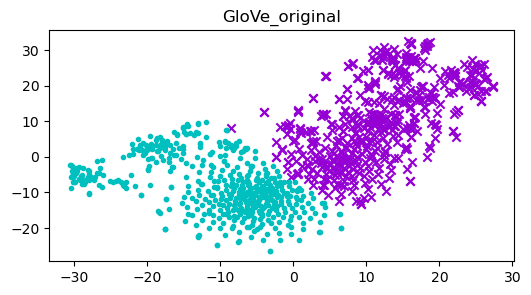

In [29]:
# Getting the clusters for the 1000 most biased words in the original GloVe
gendered_vectors = utils.extract_vectors(
    male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      np.array(gendered_vectors), 'GloVe_original', y_true, random_state=42)




Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False
precision 0.688
Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True
precision 0.313
Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False
precision 0.315
Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True
precision 0.684
Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False
precision 0.684
Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True
precision 0.684
Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False
precision 0.688
Experiment_7 , normalize_direction: True , normalize_vectors: None , centralize: True
precision 0.313
Experiment_8 , normalize_direction: True , normalize_vectors: after , centralize: False
precision 0.316
Experiment_9 , normalize_direction: True , normalize_vectors: af

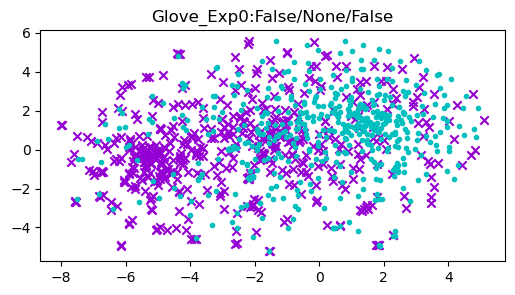

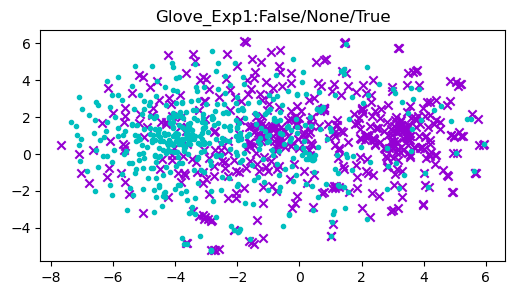

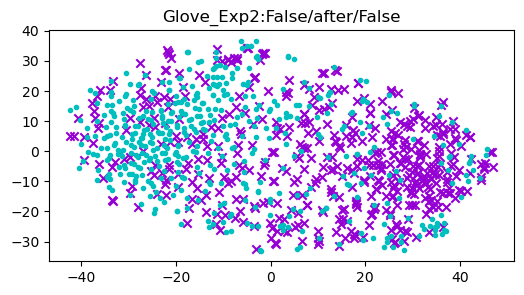

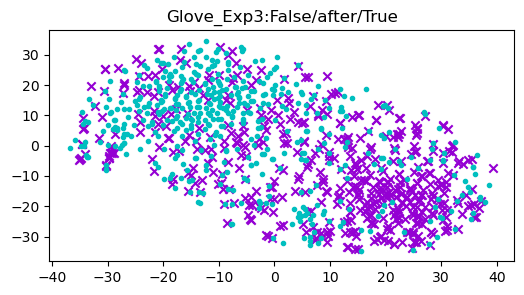

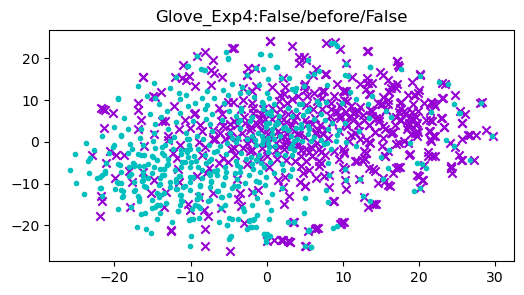

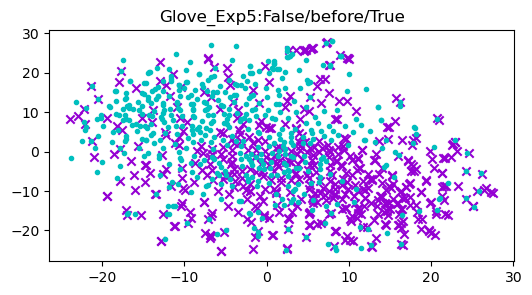

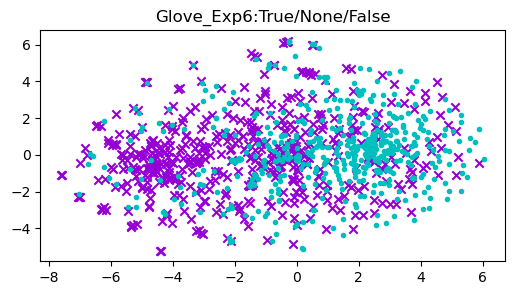

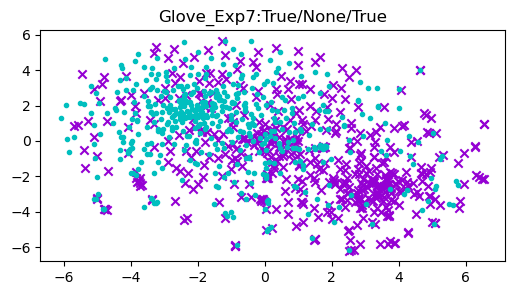

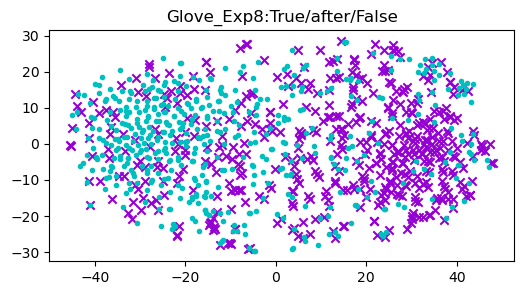

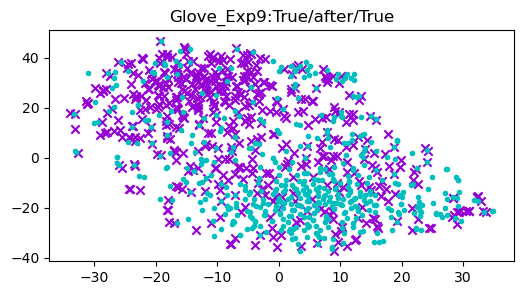

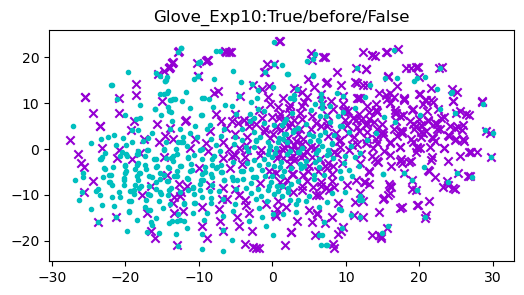

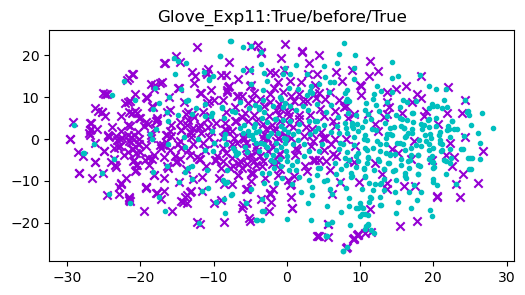

In [30]:
#Now lets visualize the clusters for all the experiments
visualizing_all_clusters(grand_dict, parameters,
                         male_words + female_words, y_true,42)




  ### Random Words Clusters
  Although debiasing algorithms transform all the embedding vectors, rarely do they report changes in random words, here I explore the closest words to a random list of words (following Ravfogel). I then plot the original neighbors in the debiased embeddings to evaluate what happened to the original clusters. All the clusters seem disentangled. However, this result must be taken with a grain of salt because tSNE, the plotting algorithm underpinning the plots, modifies the distances between points, although it mostly maintains clusters.

In [31]:
#Finding random words from the vocabulary
from sklearn.manifold import TSNE
import numpy as np
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=20)
#Let's take a look at the random words
random_words

array(['clouds', 'italy', 'anymore', 'cardinals', 'honest', 'eventual',
       'community', 'staying', 'sadr', 'vertical', 'henry', 'love',
       'rubin', 'drawn', 'monument', 'breast', 'jeffrey', 'pass',
       'rushed', 'maryland'], dtype='<U18')

In [ ]:
#Function to find the neighbors before and after debiasing. It prints the results as a sanity check
def get_random_words_clusters(grand_dict, vectors_cleaned,vocab_cleaned, parameters_df, random_words, topn):
    model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)

    for i in range(len(parameters_df)):
        debiased_vectors=grand_dict[i]['vectors'] 
        debiased_vocab=grand_dict[i]['vocab']
        model_debiased = create_KeyedVectors(debiased_vectors, debiased_vocab, 300)

        words_before_after=finding_neighbors_before_after(random_words, model_original, model_debiased, topn=topn)
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        print(words_before_after)
        
get_random_words_clusters(grand_dict, vectors_cleaned,vocab_cleaned, parameters, random_words, 3)



In [33]:
#Function to plot the position of neighbors to random words before and after debiasing.
def plot_random_words_clusters(parameters_df, random_words, topn):
    model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)
    for i in range(len(parameters_df)):
        debiased_vectors = grand_dict[i]['vectors']
        debiased_vocab = grand_dict[i]['vocab']
        model_debiased = create_KeyedVectors(
            debiased_vectors, debiased_vocab, 300)
        
        #This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
        keys = random_words
        embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
            keys, model_original, model_debiased, topn)

        n, m, k = embedding_clusters.shape
        tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                                init='pca', n_iter=3500, random_state=42)
        embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
                                embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
                                db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        
        if i==0:
            tsne_plot_similar_words('Similar words before Debiasing',
                                keys, embeddings_en_2d, word_clusters, 0.7)


            tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)
        else:
            tsne_plot_similar_words('Similar words after Debiasing',
                                    keys, db_embeddings_en_2d, word_clusters, 0.7)




Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False


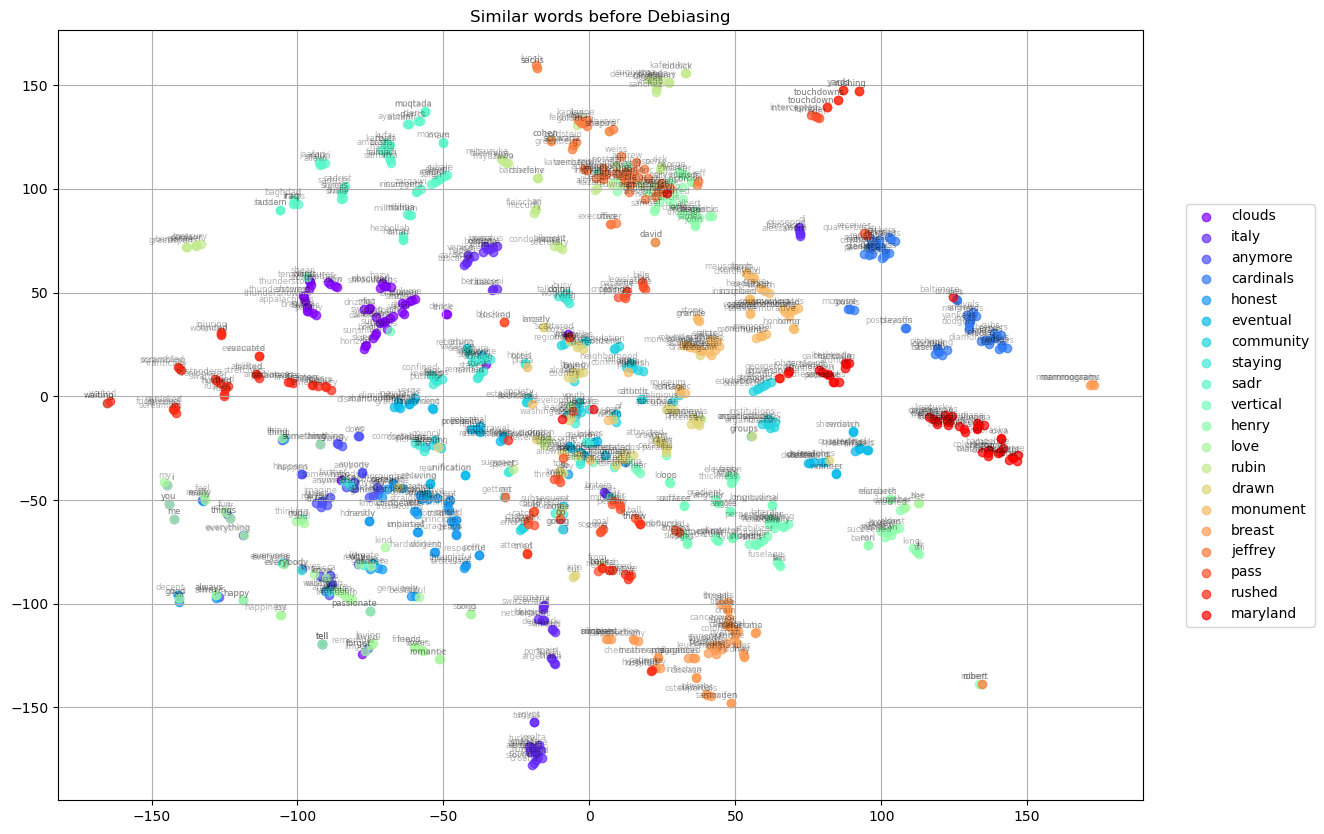

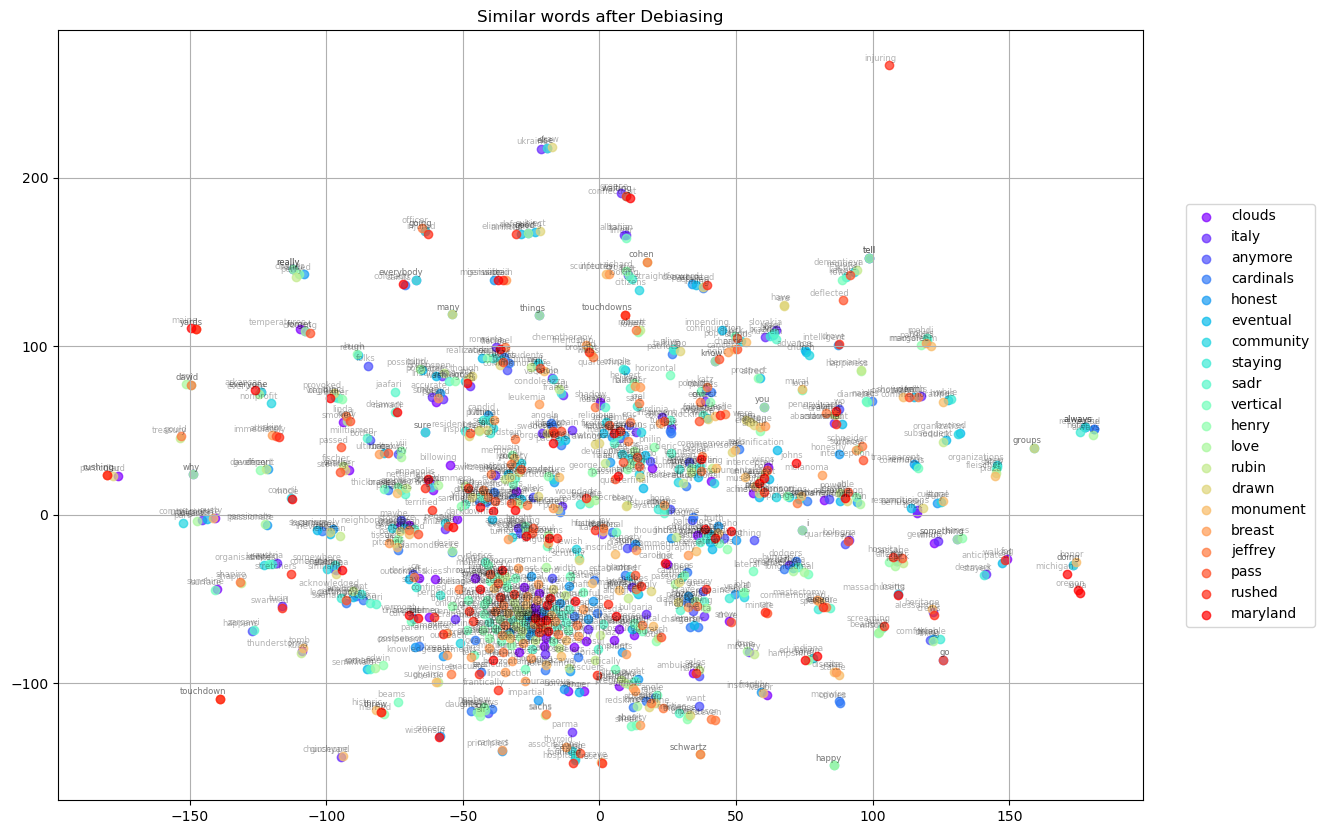

Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True


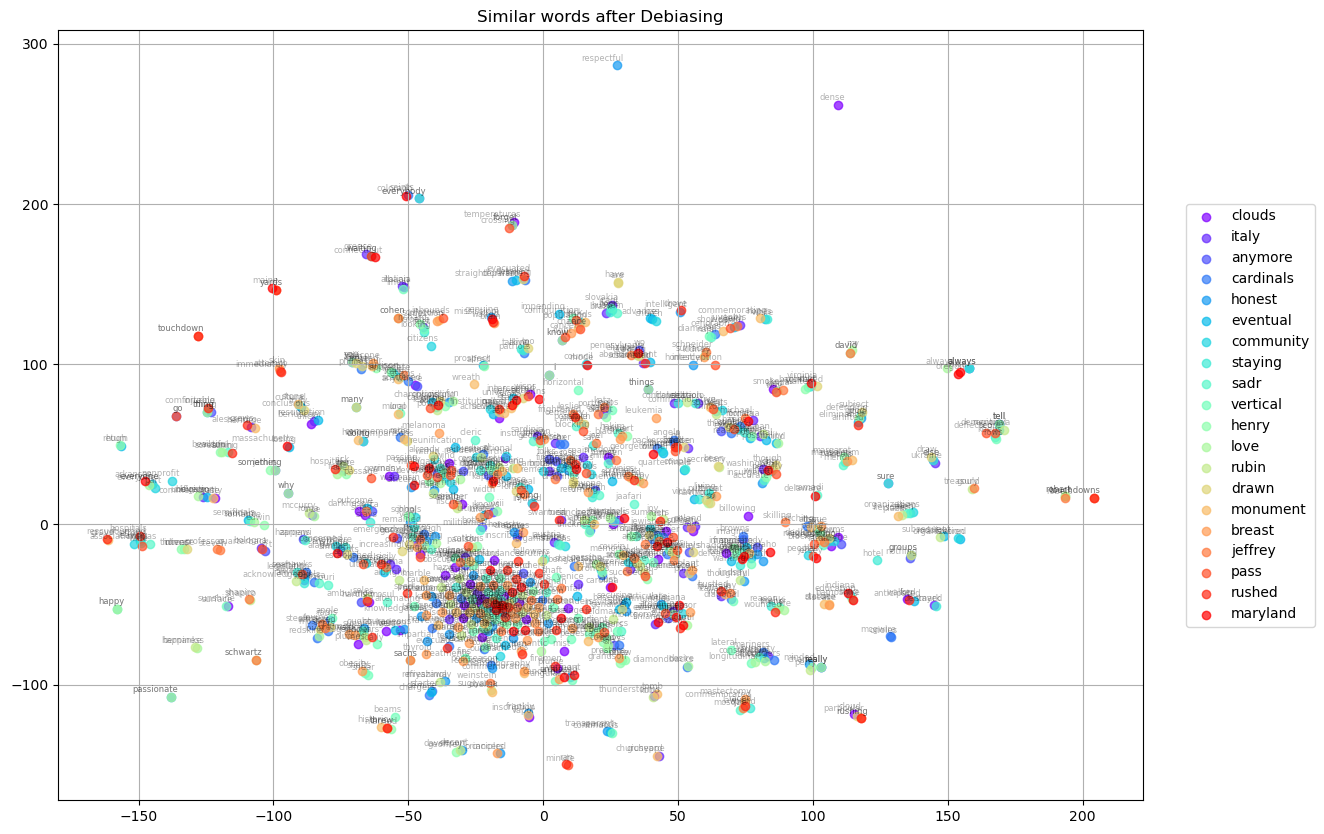

Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False


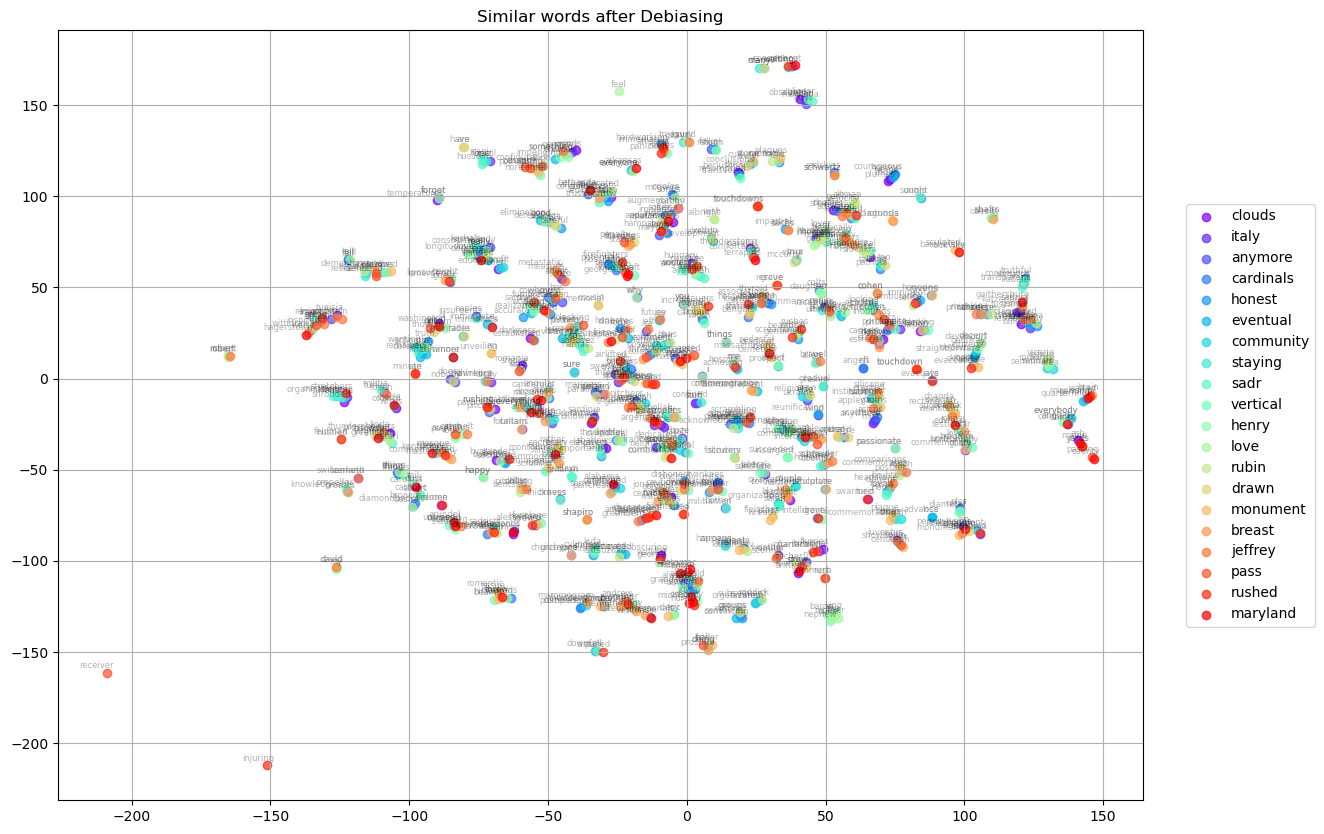

Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True


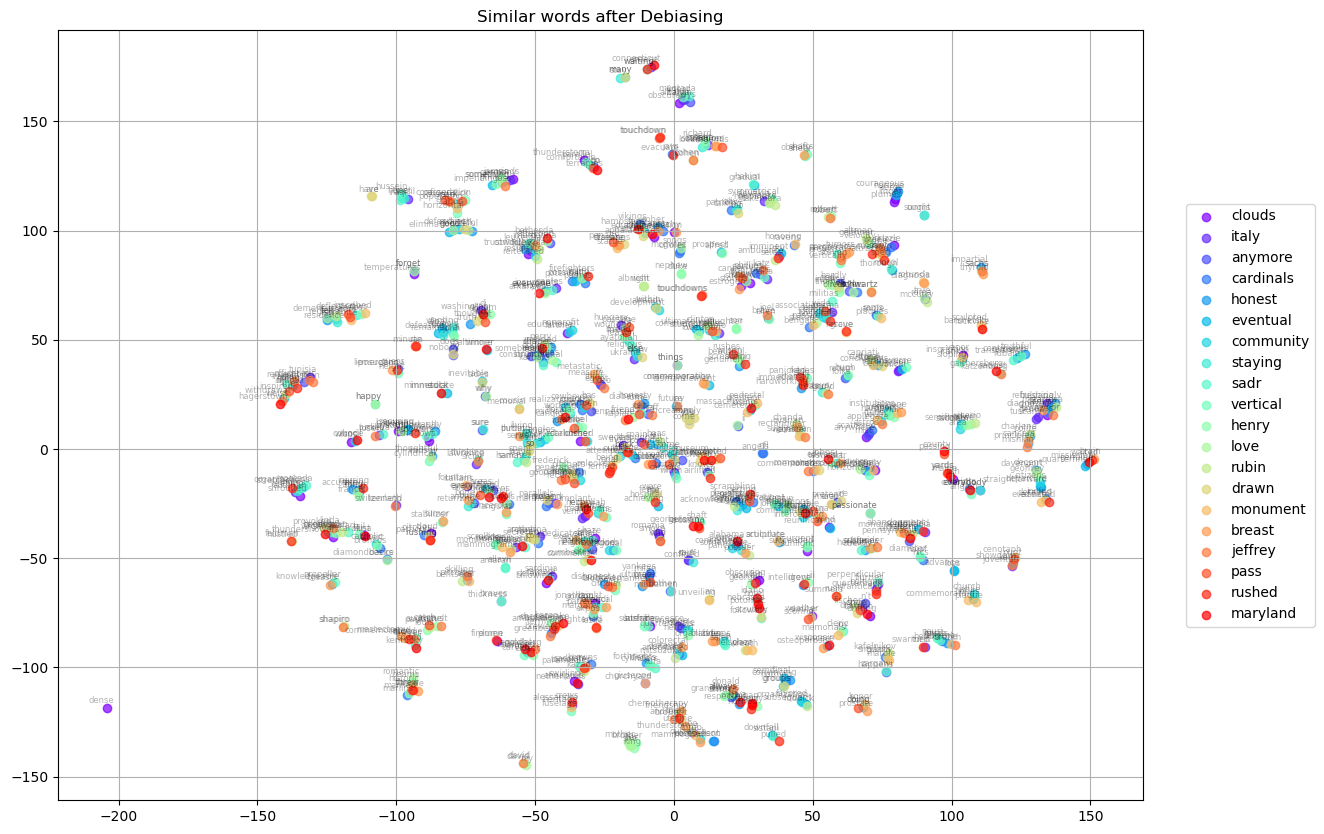

Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False


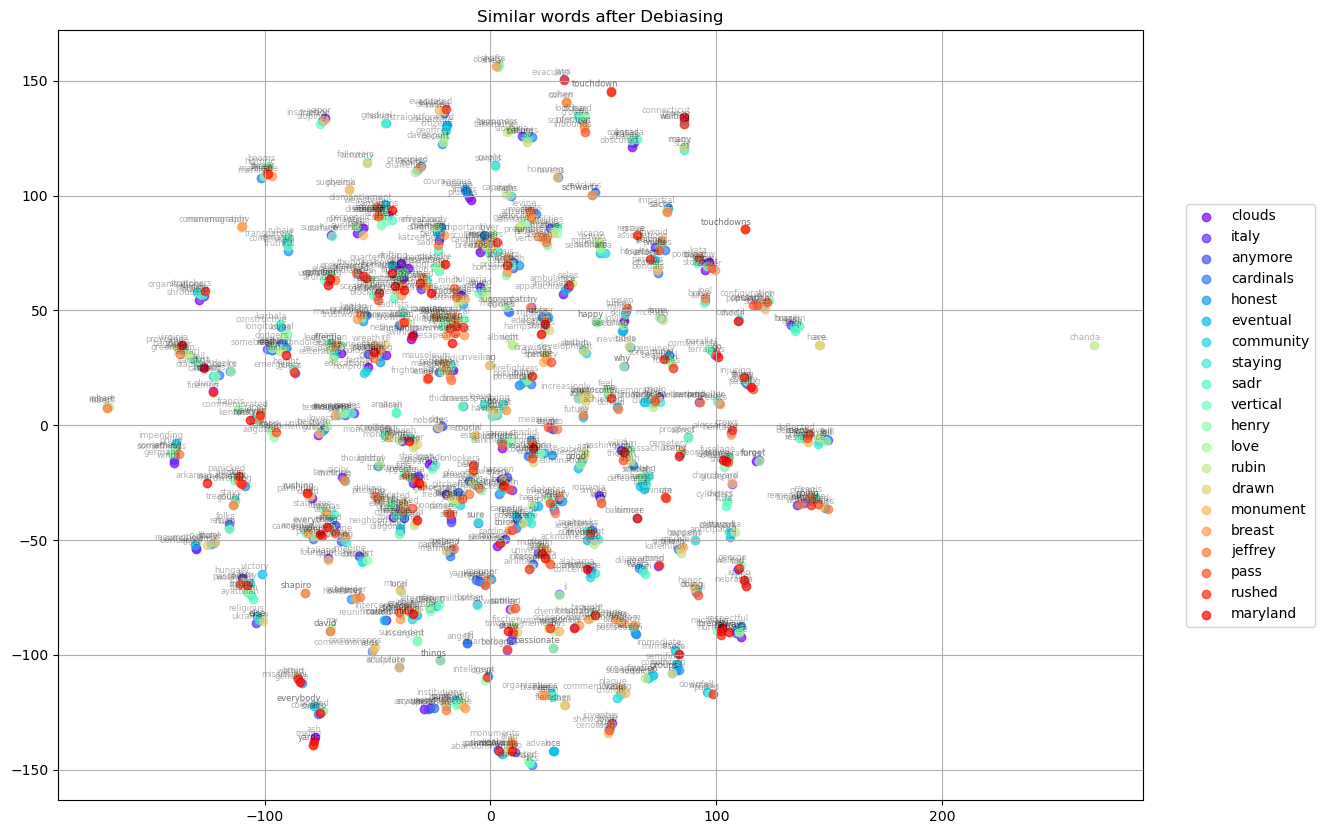

Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True


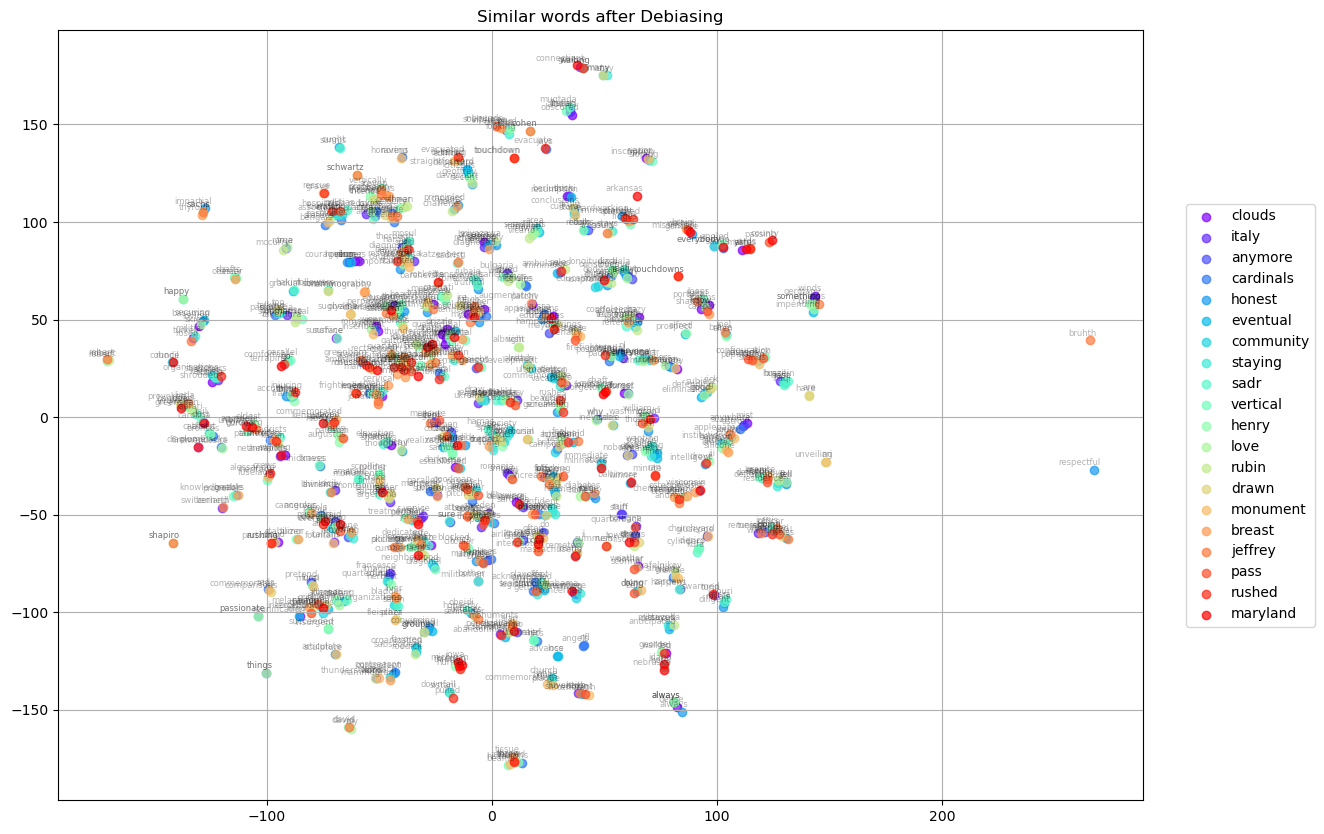

Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False


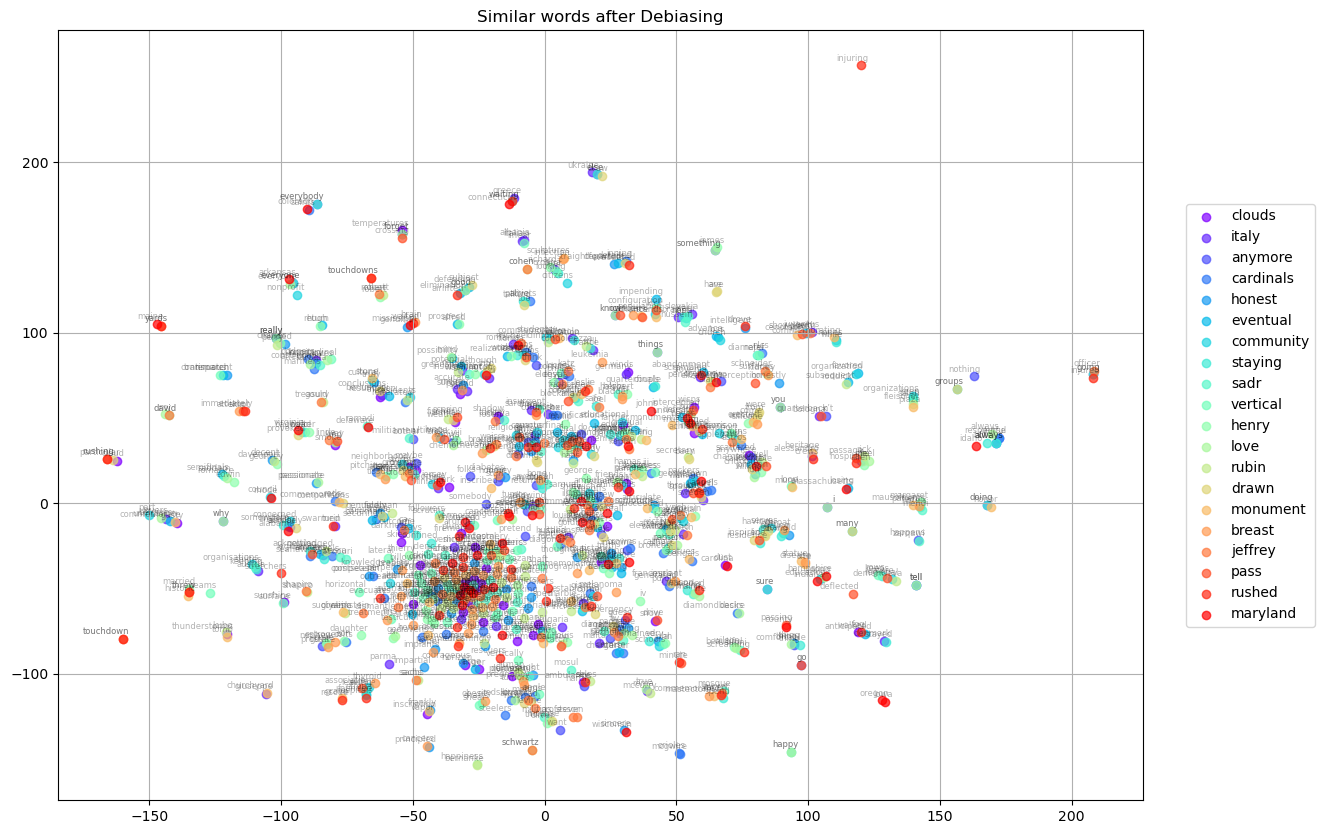

Experiment_7 , normalize_direction: True , normalize_vectors: None , centralize: True


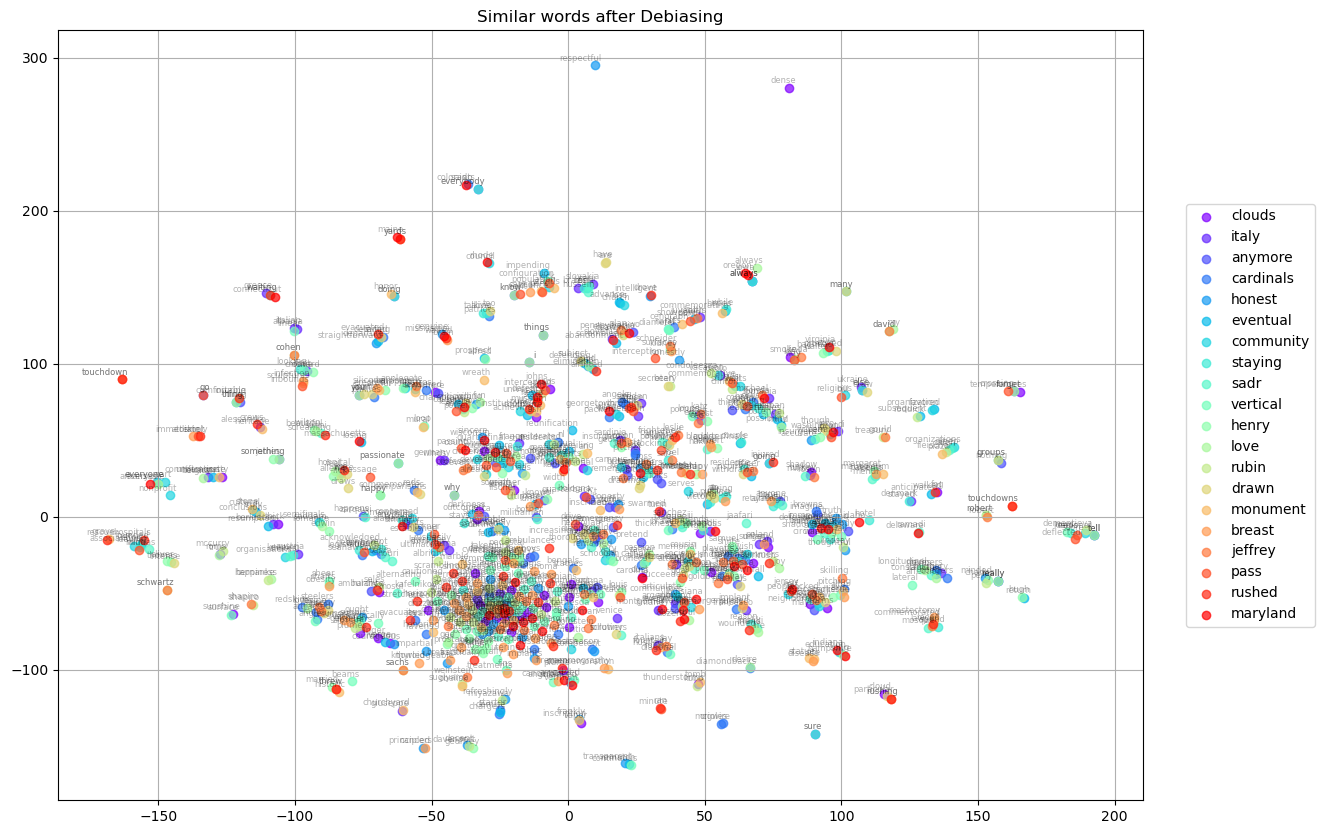

Experiment_8 , normalize_direction: True , normalize_vectors: after , centralize: False


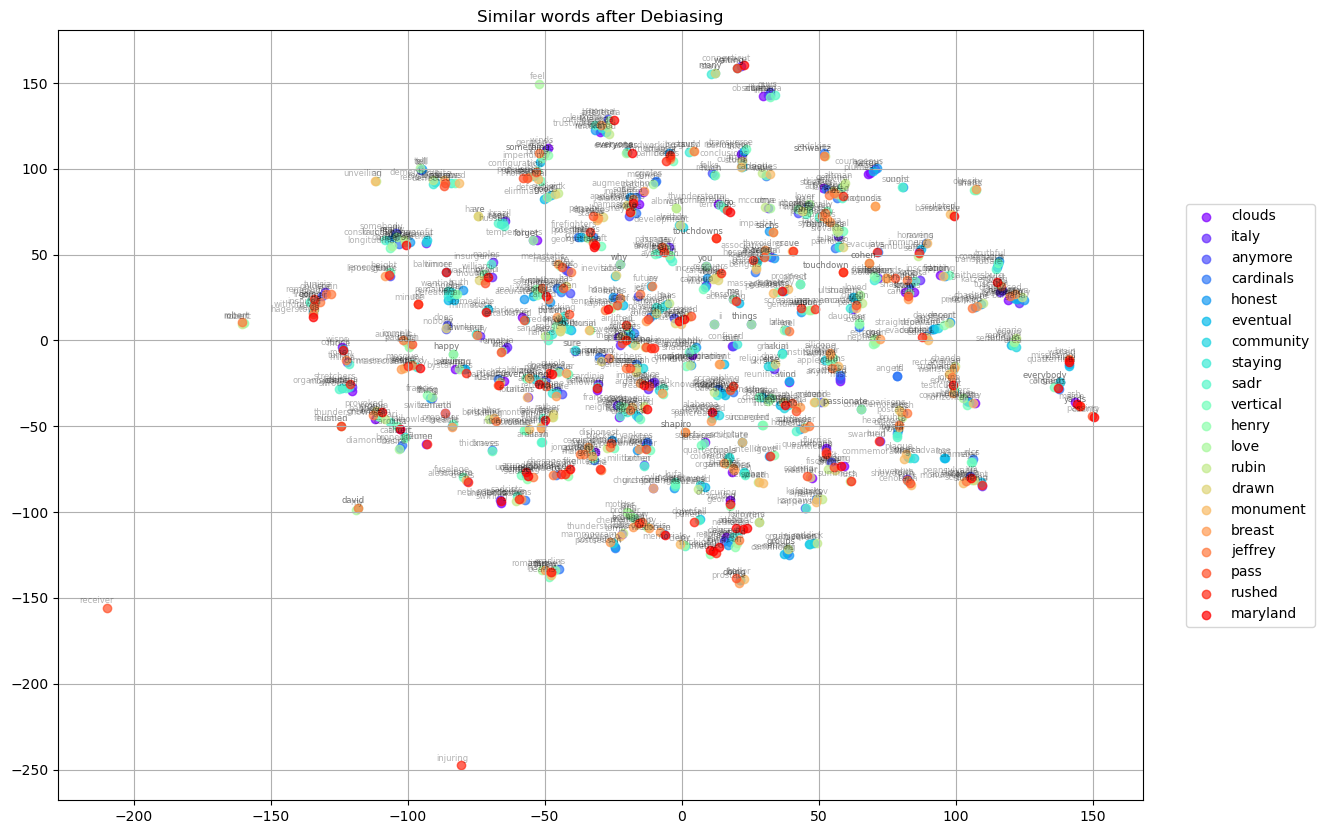

Experiment_9 , normalize_direction: True , normalize_vectors: after , centralize: True


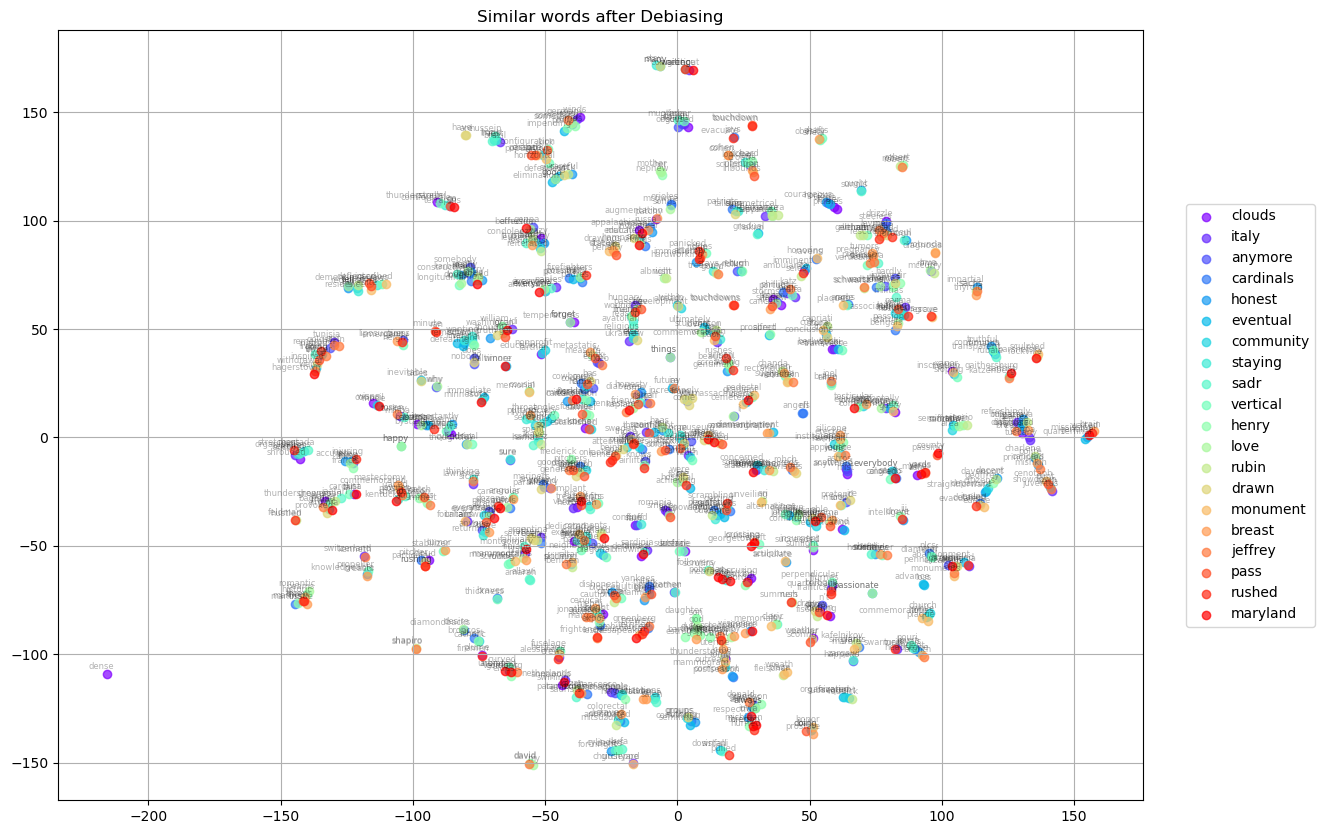

Experiment_10 , normalize_direction: True , normalize_vectors: before , centralize: False


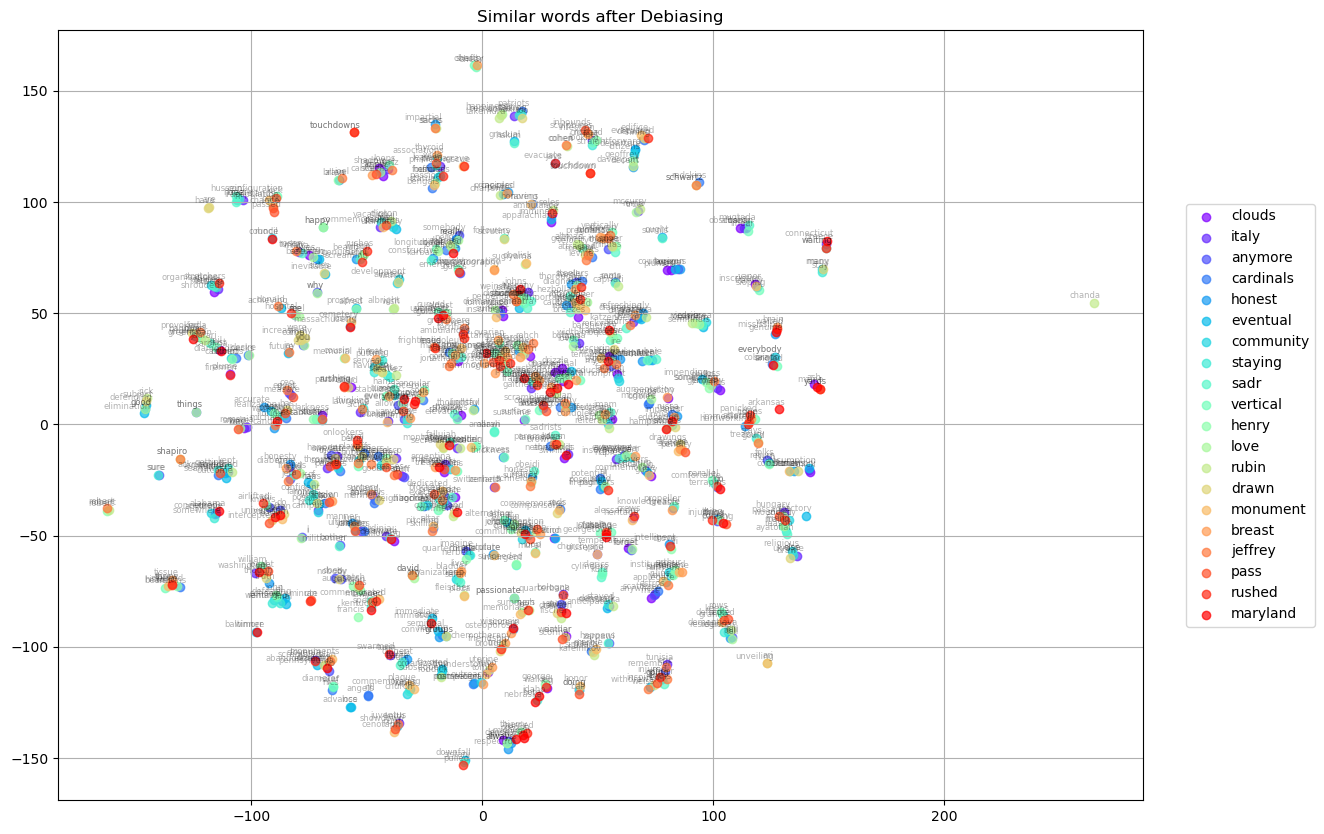

Experiment_11 , normalize_direction: True , normalize_vectors: before , centralize: True


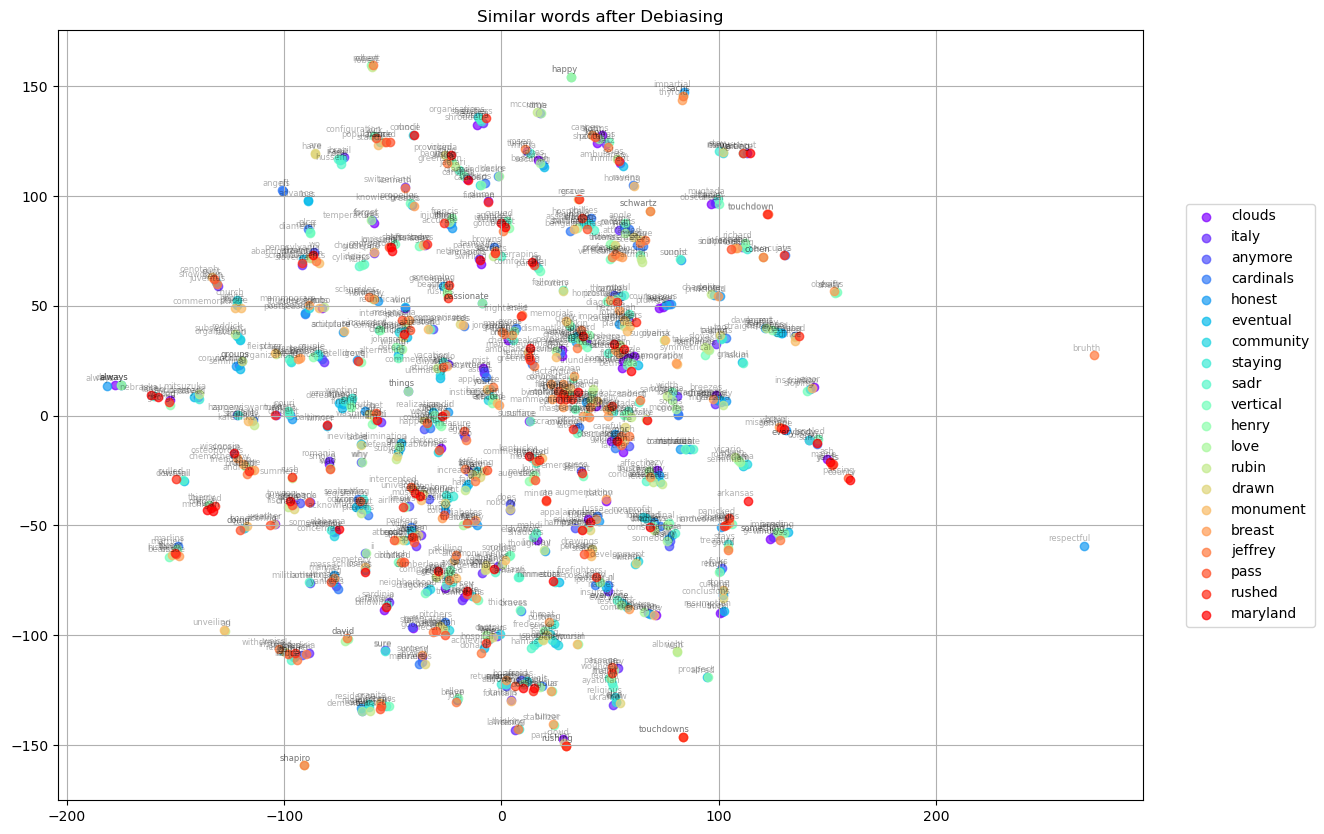

In [34]:
#obtaining the plots for the random words
plot_random_words_clusters(parameters, random_words, 50)

  ### Saving Embeddings on a txt file.


In [ ]:
#Save the debiased vectors for future use
for i in range(len(parameters)):
  glove.save_in_word2vec_format(
      grand_dict[i]['vectors'], grand_dict[i]['vocab'], "./Data/DebiasedVectors/vecs.300"+'exp'+str(i)+".txt")